<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/alpha/af/examples/AF2Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF2Rank
[AF2Rank](https://github.com/jproney/AF2Rank) implemented using ColabDesign. 

In [1]:
#@title ## Setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git
  # for debugging
  ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

In [41]:
#@title import libraries
from colabdesign import clear_mem, mk_af_model
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

def get_score(model, wt_batch=None):
  score = model.aux["log"]

  score["plddt"] = 1 - score["plddt"]
  score["pae"] = score["pae"] * 31.0

  i_xyz = model._inputs["batch"]["all_atom_positions"][:,1]
  o_xyz = np.array(model.aux["atom_positions"][:,1])

  # TMscore to input/output
  if wt_batch is not None:
    n_xyz = wt_batch["all_atom_positions"][:,1]
    score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
    score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

  # TMscore between input and output
  score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

  # composite score
  score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
  return score

## rank structures

In [ ]:
NAME = "1agy"
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"

# get data
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives/{NAME}.pdb
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/decoys/{NAME}.zip
%shell unzip -qqo {NAME}.zip

# setup model
clear_mem()
model = mk_af_model(protocol="fixbb", use_templates=True,
                    recycle_mode="last", num_recycles=1)
model.prep_inputs(NATIVE_PATH, chains="A")

# save wildtype inputs
wt_batch = model._inputs["batch"]
wt_seq = np.eye(20)[wt_batch["aatype"]]

In [45]:
# score no structure
model.prep_inputs(NATIVE_PATH, chains="A", rm_template_seq=True)
model.set_opt("template",dropout=1)
model.set_seq(seq=wt_seq)
model.predict(models=["model_1_ptm"], verbose=False)
scores = [get_score(model, wt_batch)]
scores[-1]["id"] = "none"

print(*[f"{k} {scores[-1][k]:.4f}" for k in ["tm_i","tm_o","tm_io","composite","ptm","plddt","rmsd"]], scores[-1]["id"])

tm_i 1.0000 tm_o 0.4600 tm_io 0.4600 composite 0.0589 ptm 0.3525 plddt 0.3633 rmsd 12.7070 none


In [46]:
# score the native structure
model.prep_inputs(NATIVE_PATH, chains="A", rm_template_seq=True)
model.set_opt("template",dropout=0)
model.set_seq(seq=wt_seq)
model.predict(models=["model_1_ptm"], verbose=False)
scores.append(get_score(model, wt_batch))
scores[-1]["id"] = "native"

print(*[f"{k} {scores[-1][k]:.4f}" for k in ["tm_i","tm_o","tm_io","composite","ptm","plddt","rmsd"]], scores[-1]["id"])

tm_i 1.0000 tm_o 0.9696 tm_io 0.9696 composite 0.7619 ptm 0.8836 plddt 0.8892 rmsd 1.0558 native


In [48]:
# score the decoy sctructures
for decoy_pdb in os.listdir(DECOY_DIR):
  decoy_path = os.path.join(DECOY_DIR, decoy_pdb)

  model.prep_inputs(decoy_path, chains="A", rm_template_seq=True)
  model.set_opt("template",dropout=0)
  model.set_seq(seq=wt_seq)
  model.predict(models=["model_1_ptm"], verbose=False)
  scores.append(get_score(model, wt_batch))
  scores[-1]["id"] = decoy_pdb
  print(*[f"{k} {scores[-1][k]:.4f}" for k in ["tm_i","tm_o","tm_io","composite","ptm","plddt","rmsd"]], scores[-1]["id"])

tm_i 0.8781 tm_o 0.9096 tm_io 0.8975 composite 0.6119 ptm 0.8243 plddt 0.8271 rmsd 2.7185 empty_tag_2354_0001_0001.pdb
tm_i 0.2043 tm_o 0.2327 tm_io 0.4350 composite 0.0388 ptm 0.2760 plddt 0.3235 rmsd 15.2193 empty_tag_218_0014_0001.pdb
tm_i 0.7774 tm_o 0.8024 tm_io 0.8172 composite 0.4930 ptm 0.7989 plddt 0.7551 rmsd 6.2983 empty_tag_636_0012_0001.pdb
tm_i 0.7154 tm_o 0.8939 tm_io 0.7555 composite 0.4654 ptm 0.8083 plddt 0.7621 rmsd 7.7180 empty_tag_1532_0001_0001.pdb
tm_i 0.6436 tm_o 0.8078 tm_io 0.7568 composite 0.3912 ptm 0.7346 plddt 0.7038 rmsd 13.3745 empty_tag_273_0013_0001.pdb
tm_i 0.8795 tm_o 0.8854 tm_io 0.8861 composite 0.5806 ptm 0.8125 plddt 0.8064 rmsd 2.9153 empty_tag_2827_0001_0001.pdb
tm_i 0.8011 tm_o 0.9123 tm_io 0.8078 composite 0.5712 ptm 0.8454 plddt 0.8365 rmsd 11.3664 empty_tag_649_0008_0001.pdb
tm_i 0.5996 tm_o 0.8235 tm_io 0.6263 composite 0.2990 ptm 0.7152 plddt 0.6676 rmsd 9.2643 empty_tag_1540_0001_0001.pdb
tm_i 0.7810 tm_o 0.9109 tm_io 0.7792 composite 0.

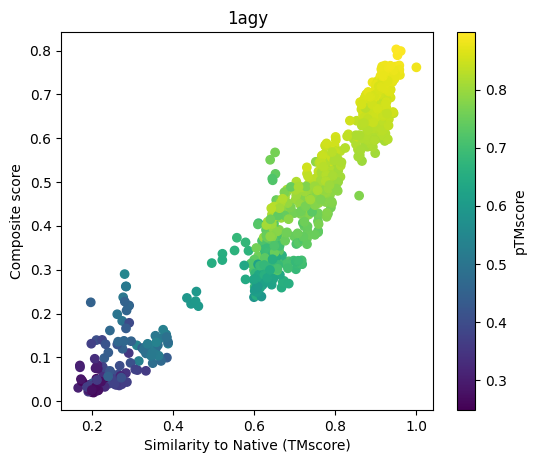

0.9605837140256934


In [31]:
plt.figure(figsize=(6,5),dpi=100)
plt.title(NAME)
x = np.array([k["tm_i"] for k in scores])
y = np.array([k["composite"] for k in scores])
c = np.array([k["ptm"] for k in scores])
plt.scatter(x,y,c=c)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("Composite score")
plt.colorbar(label="pTMscore")
plt.show()

# rank correlation to composite score
print(spearmanr(x,y).correlation)

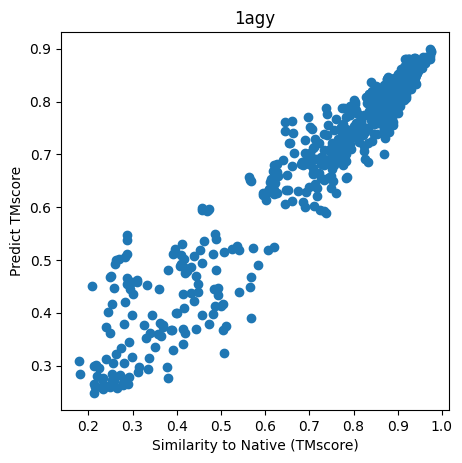

0.9550369694603732


In [30]:
plt.figure(figsize=(5,5),dpi=100)
plt.title(NAME)
x = np.array([k["tm_o"] for k in scores])
y = np.array([k["ptm"] for k in scores])
plt.scatter(x,y)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("Predict TMscore")
plt.show()

# rank correlation to pTMscore
print(spearmanr(x,y).correlation)

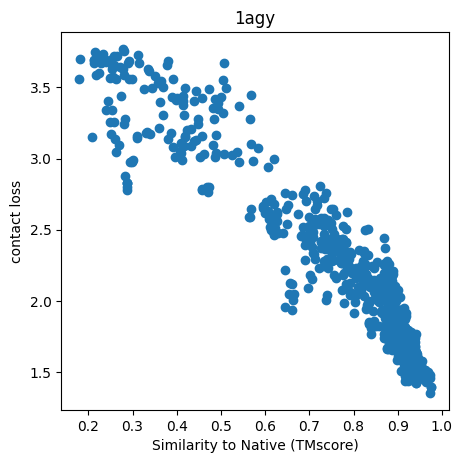

-0.9467269049834849


In [32]:
plt.figure(figsize=(5,5),dpi=100)
plt.title(NAME)
x = np.array([k["tm_o"] for k in scores])
y = np.array([k["con"] for k in scores])
plt.scatter(x,y)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("contact loss")
plt.show()

# rank correlation to pTMscore
print(spearmanr(x,y).correlation)